In [3]:
#Mount my drive- run the code, go to the link, accept.
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [8]:
#Change working directory to make it easier to access the files- (Folder inside of Colab- CNN folder- Images- Train/Test folder- Inside of each there are bunny/dog folders) 
import os
os.chdir("/content/gdrive/My Drive/Colab Notebooks/Fighting")
os.getcwd() 

'/content/gdrive/My Drive/Colab Notebooks/Fighting'

In [0]:
# Import libraries
from __future__ import print_function, division

import numpy as np
import random
import os
import glob
import cv2
import datetime
import pandas as pd
import time
import h5py
import csv

from scipy.misc import imresize, imsave

from sklearn.metrics import log_loss, confusion_matrix
from sklearn.utils import shuffle
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold
from PIL import Image, ImageChops, ImageOps

import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import RMSprop
from keras import backend as K
from keras.callbacks import EarlyStopping, Callback
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras import optimizers
from keras.models import Sequential, model_from_json
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Activation, Dropout, Flatten, Dense, BatchNormalization
#Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
# use ImageDataGenerator to preprocess the data
from keras.preprocessing.image import ImageDataGenerator

In [0]:
#Giving labels to the images: 1 for Jab, 0 for Hook

path = "/content/gdrive/My Drive/Colab Notebooks/Fighting"
files = os.listdir(path)
categories = []

for filename in files:
    category = filename.split('.')[0]
    if 'Hook' in category:
        categories.append(0)
    elif 'Jab' in category:
        categories.append(1)
    else: pass
df = pd.DataFrame({
    'filename': files,
    'category': categories
})

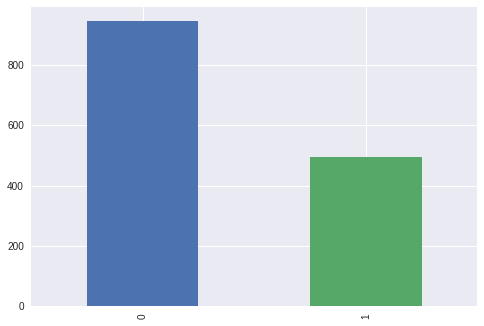

In [27]:
#Bar chart for the categories
df['category'].value_counts().plot.bar()

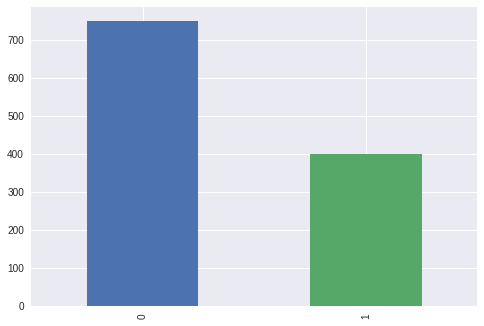

In [31]:
#Prepare Test and Train Data
#, random_state=42
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=8)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

train_df['category'].value_counts().plot.bar()

total_train = train_df.shape[0] #the number of images in the training df
total_validate = validate_df.shape[0]  #the number of images in the validate df
batch_size=15

In [0]:
#FAST_RUN = False
IMAGE_WIDTH=96
IMAGE_HEIGHT=96
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 # RGB color

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3,3), activation="relu"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

In [39]:
#Traning Generator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/content/gdrive/My Drive/Colab Notebooks/Fighting", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 1149 images belonging to 2 classes.


In [40]:
#Validation Generator

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/content/gdrive/My Drive/Colab Notebooks/Fighting", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary',
    batch_size=batch_size
)

Found 288 images belonging to 2 classes.


Found 1 images belonging to 1 classes.


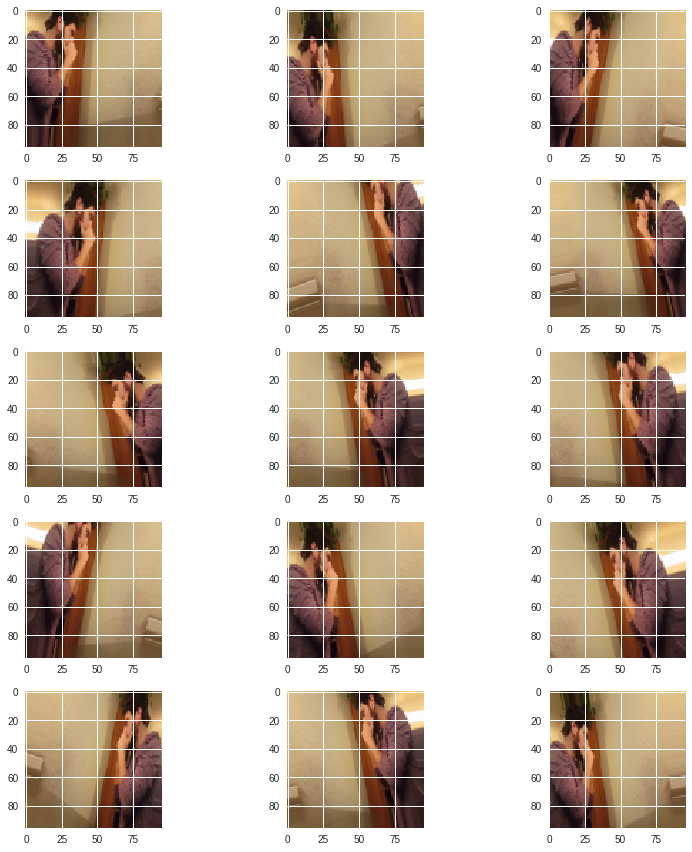

In [41]:
#See how our generator work

example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/content/gdrive/My Drive/Colab Notebooks/Fighting", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='binary'
)

plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

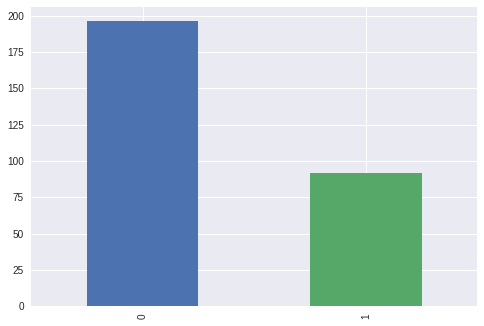

In [42]:
validate_df['category'].value_counts().plot.bar()

In [0]:
#Early Stop
earlystop = EarlyStopping(patience=10)

#Learning Rate Reduction
#We will reduce the learning rate when then accuracy not increase for 2 steps
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

callbacks = [earlystop, learning_rate_reduction]

In [44]:
#Fit Model
#epochs=3 if FAST_RUN else 25
history = model.fit_generator(
    train_generator, 
    epochs=25,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

Epoch 1/25
76/76 [==============================] - 392s 5s/step - loss: 2.6959 - acc: 0.7868 - val_loss: 0.4288 - val_acc: 0.9509
Epoch 2/25
76/76 [==============================] - 33s 437ms/step - loss: 2.3297 - acc: 0.8494 - val_loss: 2.6803 - val_acc: 0.8278
Epoch 3/25
76/76 [==============================] - 35s 457ms/step - loss: 1.8890 - acc: 0.8746 - val_loss: 8.0691 - val_acc: 0.4872

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 4/25
76/76 [==============================] - 34s 451ms/step - loss: 1.4126 - acc: 0.9006 - val_loss: 4.5827 - val_acc: 0.6703
Epoch 5/25
76/76 [==============================] - 35s 458ms/step - loss: 1.6548 - acc: 0.8860 - val_loss: 3.4222 - val_acc: 0.7839

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 6/25
76/76 [==============================] - 34s 450ms/step - loss: 1.6088 - acc: 0.8860 - val_loss: 0.1597 - val_acc: 0.9780
Epoch 7/25
76/76 [========================

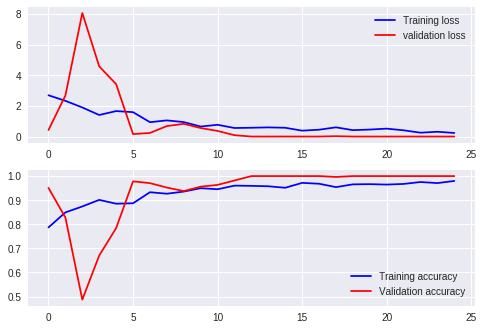

In [45]:
#Virtualize Training

fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

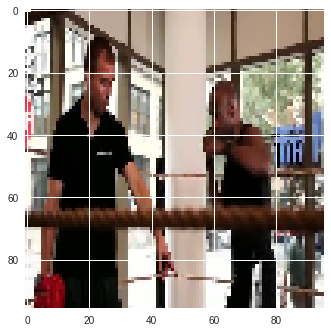

In [113]:
#Check out an image + prediction

test_image = load_img('Hook47.jpg', target_size = (96, 96))
plt.imshow(test_image)
plt.show()

In [114]:
test_image = img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)
classes = model.predict_classes(test_image)
result = model.predict(test_image)
print (classes)
if result[[0]] == 1:
  print ('Jab!')
else:
    print ('Hook!')

[[0]]
Hook!


In [0]:
#This happens when you use Dropout, since the behaviour when training and testing are different.

#When training, a percentage of the features are set to zero (50% in your case since you are using Dropout(0.5)). When testing, all features are used (and are scaled appropriately). So the model at test time is more robust - and can lead to higher testing accuracies.